# OCR by transformer

- Learner : shenhao
- Date : 2021.10.19

> **colab 运行**
> ```python
> from google.colab import drive
> drive.mount('/content/drive')
> import os
> os.chdir("drive/My Drive/Colab Notebooks/Recognition_by_transformer/code")
> ```

In [1]:
import os
os.getcwd()

'D:\\shenhao\\Datawhale\\Recognition_by_transformer\\code'

## 执行数据集分析脚本

In [2]:
# encoding=utf-8
!python analysis_recognition_dataset.py

数据集中包含字符最多的label长度为21
训练集中出现的label
{'[': 2, '0': 182, '6': 38, ']': 2, '2': 119, '-': 68, '3': 50, 'C': 593, 'a': 843, 'r': 655, 'p': 197, 'k': 96, 'E': 1421, 'X': 110, 'I': 861, 'T': 896, 'R': 836, 'f': 133, 'u': 293, 's': 557, 'i': 651, 'o': 659, 'n': 605, 'l': 408, 'e': 1055, 'v': 123, 'A': 1189, 'U': 319, 'O': 965, 'N': 785, 'c': 318, 't': 563, 'm': 202, 'W': 179, 'H': 391, 'Y': 229, 'P': 389, 'F': 259, 'G': 345, '?': 5, 'S': 1161, 'b': 88, 'h': 299, ' ': 50, 'g': 171, 'L': 745, 'M': 367, 'D': 383, 'd': 257, '$': 46, '5': 77, '4': 44, '.': 95, 'w': 97, 'B': 331, '1': 184, '7': 43, '8': 44, 'V': 158, 'y': 161, 'K': 163, '!': 51, '9': 66, 'z': 12, ';': 3, '#': 16, 'j': 15, "'": 51, 'J': 72, ':': 19, 'x': 27, '%': 28, '/': 24, 'q': 3, 'Q': 19, '(': 6, ')': 5, '\\': 8, '"': 8, '´': 3, 'Z': 29, '&': 9, 'É': 1, '@': 4, '=': 1, '+': 1}
训练集+验证集中出现的label
{'[': 2, '0': 232, '6': 44, ']': 2, '2': 139, '-': 87, '3': 69, 'C': 893, 'a': 1200, 'r': 935, 'p': 317, 'k': 137, 'E': 2213, 'X': 181, 'I

## 准备工作

### 导入库

In [3]:
import os
import time
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# torch相关包
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# 导入工具类包
from analysis_recognition_dataset import load_lbl2id_map, statistics_max_len_label
from transformer import *
from train_utils import *

### 数据集构造和参数设定

#### set parameters

In [4]:
# TODO set parameters
# 数据集根目录，请将数据下载到此位置
base_data_dir = '../dataset/ICDAR_2015/'
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
nrof_epochs = 20
batch_size = 64
model_save_path = './log/ex1_ocr_model.pth'
print('Using {} device'.format(device))

Using cuda device


#### The preparatory work for  datasets

In [5]:
# 读取label-id映射关系记录文件
lbl2id_map_path = os.path.join(base_data_dir, 'lbl2id_map.txt')
lbl2id_map, id2lbl_map = load_lbl2id_map(lbl2id_map_path)

# 统计数据集中出现的所有的label中包含字符最多的有多少字符，数据集构造gt信息需要用到
train_lbl_path = os.path.join(base_data_dir, 'train_gt.txt')
valid_lbl_path = os.path.join(base_data_dir, 'valid_gt.txt')
train_max_label_len = statistics_max_len_label(train_lbl_path)  # train_max_label_len = 19
valid_max_label_len = statistics_max_len_label(valid_lbl_path)  # valid_max_label_len = 21

# 数据集中字符数最多的一个case作为制作的gt的sequence_len
sequence_len = max(train_max_label_len, valid_max_label_len) # sequence_len = 21

In [6]:
lbl2id_map, id2lbl_map

({' ': 46,
  '!': 64,
  '"': 81,
  '#': 68,
  '$': 52,
  '%': 74,
  '&': 84,
  "'": 70,
  '(': 78,
  ')': 79,
  '+': 88,
  '-': 8,
  '.': 55,
  '/': 75,
  '0': 4,
  '1': 58,
  '2': 7,
  '3': 9,
  '4': 54,
  '5': 53,
  '6': 5,
  '7': 59,
  '8': 60,
  '9': 65,
  ':': 72,
  ';': 67,
  '=': 87,
  '?': 42,
  '@': 86,
  'A': 29,
  'B': 57,
  'C': 10,
  'D': 50,
  'E': 15,
  'F': 40,
  'G': 41,
  'H': 37,
  'I': 17,
  'J': 71,
  'K': 63,
  'L': 48,
  'M': 49,
  'N': 32,
  'O': 31,
  'P': 39,
  'Q': 77,
  'R': 19,
  'S': 43,
  'T': 18,
  'U': 30,
  'V': 61,
  'W': 36,
  'X': 16,
  'Y': 38,
  'Z': 83,
  '[': 3,
  '\\': 80,
  ']': 6,
  'a': 11,
  'b': 44,
  'c': 33,
  'd': 51,
  'e': 27,
  'f': 20,
  'g': 47,
  'h': 45,
  'i': 23,
  'j': 69,
  'k': 14,
  'l': 26,
  'm': 35,
  'n': 25,
  'o': 24,
  'p': 13,
  'q': 76,
  'r': 12,
  's': 22,
  't': 34,
  'u': 21,
  'v': 28,
  'w': 56,
  'x': 73,
  'y': 62,
  'z': 66,
  '´': 82,
  'É': 85,
  'é': 89,
  '■': 1,
  '□': 2,
  '☯': 0},
 {0: '☯',
  1: '■'

## Dataset构建

### 图片预处理

假设图片尺寸为 $ [batch\_size, 3, H_i, W_i] $

经过网络后的特征图尺寸为 $ [batch\_size, C_f, H_f ,W_f] $

基于之前对于数据集的分析，图片基本都是水平长条状的，图像内容是水平排列的字符组成的单词。那么图片空间上同一纵向切片的位置，基本只有一个字符，因此纵向分辨率不需要很大，那么取 $H_f=1$
即可；而横向的分辨率需要大一些，我们需要有不同的embedding来编码水平方向上不同字符的特征。

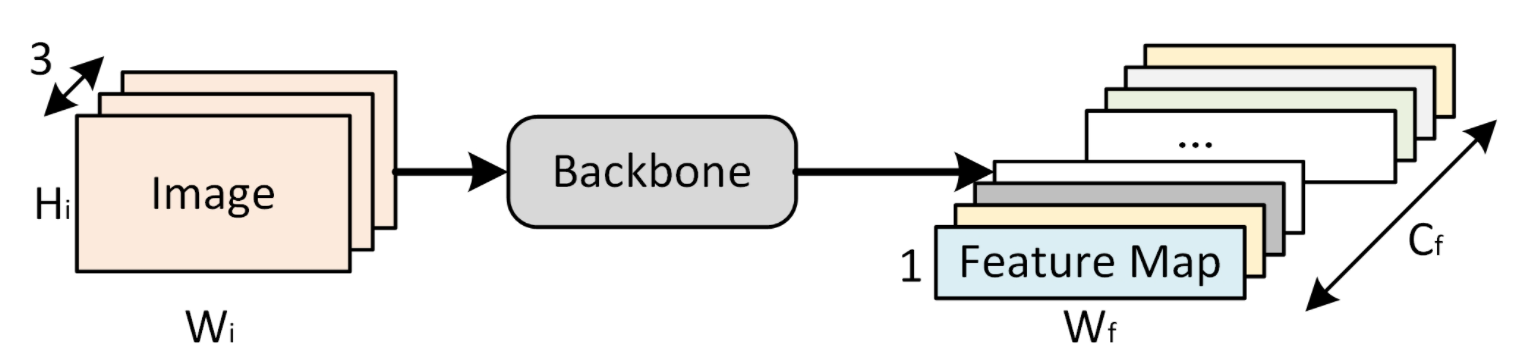

这里，我们就用最经典的resnet18网络作为backbone，由于其下采样倍数为32，最后一层特征图channel数为512，那么:

$ H_i = H_f * 32 = 32 $

$ C_f = 512 $

那么输入图片的宽度如何确定呢？这里给出两种方案，如下图所示：

<img src="https://raw.githubusercontent.com/datawhalechina/dive-into-cv-pytorch/master/markdown_imgs/chapter06/6.2/two_resize.jpg">

**方法一：** 设定一个固定尺寸，将图像保持其宽高比进行resize，右侧空余区域进行padding；

**方法二：** 直接将原始图像强制resize到一个预设的固定尺寸。

> **注：这里不妨先思考下，你觉得哪种方案比较好呢？**  
这里作者选择了方法一，因为图片的宽高比和图片中单词的字符数量是大致呈正比的，如果预处理时保持住原图片的宽高比，那么特征图上每一个像素对应原图上字符区域的范围就是基本稳定的，这样或许有更好的预测效果。

这里还有个细节，观察上图你会发现，每个宽：高=1:1的区域内，基本都分布着2-3个字符，因此我们实际操作时也没有严格的保持宽高比不变，而是将宽高比提升了3倍，即先将原始图片宽度拉长到原来的3倍，再保持宽高比，将高resize到32。

> **注：这里建议再次停下来思考下，刚刚这个细节又是为什么？**  
这样做的目的是让图片上每一个字符，都有至少一个特征图上的像素与之对应，而不是特征图宽维度上一个像素同时编码了原图中的多个字符的信息，这样我认为会对transformer的预测带来不必要的困难。

确定了resize方案，$ W_i $ 具体设置为多少呢？结合前面我们对数据集做分析时的两个重要指标，数据集label中最长字符数为21，最长的宽高比8.6，我们将最终的宽高比设置为 24:1，因此汇总一下各个参数的设置：

$ H_i = H_f * 32 = 32 $

$ W_i = 24 * H_i = 768 $

$ C_f = 512, H_f = 1, W_f = 24 $

In [7]:
img_dir = base_data_dir + 'train'
img_path = os.path.join(img_dir, 'word_2.png')
img_path

'../dataset/ICDAR_2015/train/word_2.png'

In [8]:
# load image
img = Image.open(img_path).convert('RGB')
max_ratio =8 
# 对图片进行大致等比例的缩放
# 将高缩放到32，宽大致等比例缩放，但要被32整除
w, h = img.size
ratio = round((w / h) * 3)   # 将宽拉长3倍，然后四舍五入
if ratio == 0:
    ratio = 1 
if ratio > max_ratio:
    ratio = max_ratio
h_new = 32
w_new = h_new * ratio
img_resize = img.resize((w_new, h_new), Image.BILINEAR)

# 对图片右半边进行padding，使得 宽/高 比例固定=self.max_ratio
# Image.new(mode, size, color=0)
img_padd = Image.new('RGB', (32*max_ratio, 32), (0,0,0)) # (0,0,0)为RGB三通道的填充色
img_padd.paste(img_resize, (0, 0))  # 在(0,0)位置起进行paste

通过下图可以看到,在变化后的IMAGE中每一个32\*32的区域中都只包括了一个字符,因此特征图上的像素不会同时编码原图中的多个字符的信息.只可能对应于一个字符.

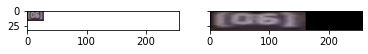

In [9]:
_, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(np.array(img))
ax2.imshow(np.array(img_padd))
plt.show()

### 图像增广

图像增广并不是重点，这里我们除了上述的resize方案外，仅对图像进行常规的随机颜色变换和归一化操作。

In [10]:
# transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
# transforms.ColorJitter?

In [11]:
# 定义随机颜色变换
color_trans = transforms.ColorJitter(0.1, 0.1, 0.1) # range: 0.9-1.1 for brightness,contrast and saturation
# 定义 Normalize
trans_Normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # torchvision.transforms.Normalize(mean, std)
])
# 随机颜色变换
img_input_color = color_trans(img_padd)
# Normalize
img_input_norm = trans_Normalize(img_input_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


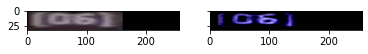

In [12]:
_, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(np.array(img_input_color))
ax2.imshow(np.transpose(img_input_norm, (1, 2, 0)))
plt.show()

### 完整代码

In [13]:
class Recognition_Dataset(object):

    def __init__(self, dataset_root_dir, lbl2id_map, sequence_len, max_ratio, phase='train', pad=0):

        if phase == 'train':
            self.img_dir = os.path.join(dataset_root_dir, 'train')
            self.lbl_path = os.path.join(dataset_root_dir, 'train_gt.txt')
        else:
            self.img_dir = os.path.join(dataset_root_dir, 'valid')
            self.lbl_path = os.path.join(dataset_root_dir, 'valid_gt.txt')
        self.lbl2id_map = lbl2id_map
        self.pad = pad   # padding标识符的id，默认0
        self.sequence_len = sequence_len    # 序列长度
        self.max_ratio = max_ratio * 3      # 将宽拉长3倍

        self.imgs_list = []
        self.lbls_list = []
        with open(self.lbl_path, 'r', encoding='utf-8') as reader:
            for line in reader:
                items = line.rstrip().split(',')
                img_name = items[0]  # img_name = 'word_2.png'
                lbl_str = items[1].strip()[1:-1]  # lbl_str = '[06]'

                self.imgs_list.append(img_name)
                self.lbls_list.append(lbl_str)

        # 定义随机颜色变换
        self.color_trans = transforms.ColorJitter(0.1, 0.1, 0.1)
        # 定义 Normalize
        self.trans_Normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        """ 
        获取对应index的图像和ground truth label，并视情况进行数据增强
        """
        img_name = self.imgs_list[index]
        img_path = os.path.join(self.img_dir, img_name)
        lbl_str = self.lbls_list[index]

        # ----------------
        # 图片预处理
        # ----------------
        # load image
        img = Image.open(img_path).convert('RGB')

        # 对图片进行大致等比例的缩放
        # 将高缩放到32，宽大致等比例缩放，但要被32整除
        w, h = img.size
        ratio = round((w / h) * 3)   # 将宽拉长3倍，然后四舍五入
        if ratio == 0:
            ratio = 1
        if ratio > self.max_ratio:
            ratio = self.max_ratio
        h_new = 32
        w_new = h_new * ratio
        img_resize = img.resize((w_new, h_new), Image.BILINEAR)

        # 对图片右半边进行padding，使得宽/高比例固定=self.max_ratio
        img_padd = Image.new('RGB', (32*self.max_ratio, 32), (0, 0, 0))
        img_padd.paste(img_resize, (0, 0))

        # 随机颜色变换
        img_input = self.color_trans(img_padd)
        # Normalize
        img_input = self.trans_Normalize(img_input)

        # ----------------
        # label处理
        # ----------------

        # 构造encoder的mask
        encode_mask = [1] * ratio + [0] * (self.max_ratio - ratio)
        encode_mask = torch.tensor(encode_mask)
        encode_mask = (encode_mask != 0).unsqueeze(0)

        # 构造ground truth label
        gt = []
        gt.append(1)    # 先添加句子起始符
        for lbl in lbl_str:
            gt.append(self.lbl2id_map[lbl])
        gt.append(2)
        # 除去起始符终止符，lbl长度为sequence_len，剩下的padding
        for i in range(len(lbl_str), self.sequence_len):
            gt.append(0)
        # 截断为预设的最大序列长度
        gt = gt[:self.sequence_len]

        # decoder的输入
        decode_in = gt[:-1]
        decode_in = torch.tensor(decode_in)
        # decoder的输出
        decode_out = gt[1:]
        decode_out = torch.tensor(decode_out)
        # decoder的mask
        decode_mask = self.make_std_mask(decode_in, self.pad)
        # 有效tokens数
        ntokens = (decode_out != self.pad).data.sum()

        return img_input, encode_mask, decode_in, decode_out, decode_mask, ntokens

    @staticmethod
    def make_std_mask(tgt, pad):
        """
        Create a mask to hide padding and future words.
        padd 和 future words 均在mask中用0表示
        """
        tgt_mask = (tgt != pad)
        tgt_mask = tgt_mask & subsequent_mask(
            tgt.size(-1)).type_as(tgt_mask.data)
        tgt_mask = tgt_mask.squeeze(0)   # subsequent返回值的shape是(1, N, N)
        return tgt_mask

    def __len__(self):
        return len(self.imgs_list)

上面的代码中还设计到几个和label处理相关的细节，属于Transformer训练相关的逻辑，之前的章节已经介绍过，这里再简单提一下：

**encode_mask**

由于我们对图像进行了尺寸调整，并根据需求对图像进行了padding，而padding的位置是没有包含有效信息的，为此需要根据padding比例构造相应encode_mask，让transformer在计算时忽略这部分无意义的区域。

**label处理**

本实验使用的预测标签与机器翻译模型训练时的标签基本一致，因此在处理方式中差异较小。

标签处理中，将label中字符转换成其对应id，并在句子开始添加起始符，句子最后添加终止符，并在不满足sequence_len长度时在剩余位置进行padding（0补位）。

**decode_mask**

一般的在decoder中我们会根据label的sequence_len生成一个上三角阵形式的mask，mask的每一行便可以控制当前time_step时，只允许decoder获取当前步时之前的字符信息，而禁止获取未来时刻的字符信息，这防止了模型训练时的作弊行为。

decode_mask经过一个特殊的函数 **make_std_mask()** 进行生成。

同时，decoder的label制作同样要考虑上对padding的部分进行mask，所以decode_mask在label被padding对应的位置处也应该进行写成False。

生成的decode_mask如下图所示：
<img src="https://raw.githubusercontent.com/datawhalechina/dive-into-cv-pytorch/master/markdown_imgs/chapter06/6.2/decode_mask.png">

以上是构建Dataset的所有细节，进而我们可以构建出DataLoader供训练使用

### DataLoader构建

In [14]:
# 构造 dataloader
max_ratio = 8    # 图片预处理时 宽/高 的最大值，不超过就保比例resize，超过会强行压缩
train_dataset = Recognition_Dataset(
    base_data_dir, lbl2id_map, sequence_len, max_ratio, 'train', pad=0)
valid_dataset = Recognition_Dataset(
    base_data_dir, lbl2id_map, sequence_len, max_ratio, 'valid', pad=0)
# loader size info:
# --> img_input: [batch_size, c, h, w] --> [64, 3, 32, 32*8*3]
# --> encode_mask: [batch_size, h/32, w/32] --> [64, 1, 24] 本文backbone采用的32倍下采样，所以除以32
# --> decode_in: [batch_size, sequence_len-1] --> [64, 20]
# --> decode_out: [batch_size, sequence_len-1] --> [64, 20]
# --> decode_mask: [batch_size, sequence_len-1, sequence_len-1] --> [64, 20, 20]
# --> ntokens: [batch_size] --> [64]
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=2)

## 模型构建

代码通过 **make_ocr_model** 和 **OCR_EncoderDecoder** 类完成模型结构搭建。

可以从 **make_ocr_model** 这个函数看起，该函数首先调用了pytorch中预训练的Resnet-18作为backbone以提取图像特征，此处也可以根据自己需要调整为其他的网络，但需要重点关注的是网络的下采样倍数，以及最后一层特征图的channel_num，相关模块的参数需要同步调整。之后调用了 **OCR_EncoderDecoder** 类完成transformer的搭建。最后对模型参数进行初始化。

在 **OCR_EncoderDecoder** 类中，该类相当于是一个transformer各基础组件的拼装线，包括 encoder 和 decoder 等，其初始参数是已存在的基本组件，其基本组件代码都在transformer.py文件中，本文将不在过多叙述。

这里再来回顾一下，图片经过backbone后，如何构造为Transformer的输入：

图片经过backbone后将输出一个维度为 **[batch_size, 512, 1, 24]** 的特征图，在不关注batch_size的前提下，每一张图像都会得到如下所示具有512个通道的1×24的特征图，如图中红色框标注所示，将不同通道相同位置的特征值拼接组成一个新的向量，并作为一个时间步的输入，此时变构造出了维度为 **[batch_size, 24, 512]** 的输入，满足Transformer的输入要求。
<img src="https://raw.githubusercontent.com/datawhalechina/dive-into-cv-pytorch/master/markdown_imgs/chapter06/6.2/transpose.jpg">

下面来看下完整的构造模型部分的代码：

In [15]:
# 模型结构
class OCR_EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    Base for this and many other models.
    """

    def __init__(self, encoder, decoder, src_embed, src_position, tgt_embed, generator):
        super(OCR_EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed    # input embedding module
        self.src_position = src_position
        self.tgt_embed = tgt_embed    # ouput embedding module
        self.generator = generator    # output generation module

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # src --> [bs, 3, 32, 768]  [bs, c, h, w]
        # src_mask --> [bs, 1, 24]  [bs, h/32, w/32]
        memory = self.encode(src, src_mask)
        # memory --> [bs, 24, 512]
        # tgt --> decode_in [bs, 20]  [bs, sequence_len-1]
        # tgt_mask --> decode_mask [bs, 20]  [bs, sequence_len-1]
        res = self.decode(memory, src_mask, tgt, tgt_mask)  # [bs, 20, 512]
        return res

    def encode(self, src, src_mask):
        # feature extract
        # src --> [bs, 3, 32, 768]
        src_embedds = self.src_embed(src)
        # 此处使用的resnet18作为backbone 输出-->[batchsize, c, h, w] --> [bs, 512, 1, 24]
        # 将src_embedds由shape(bs, model_dim, 1, max_ratio) 处理为transformer期望的输入shape(bs, 时间步, model_dim)
        # [bs, 512, 1, 24] --> [bs, 24, 512]
        src_embedds = src_embedds.squeeze(-2)
        src_embedds = src_embedds.permute(0, 2, 1)

        # position encode
        src_embedds = self.src_position(src_embedds)  # [bs, 24, 512]

        return self.encoder(src_embedds, src_mask)  # [bs, 24, 512]

    def decode(self, memory, src_mask, tgt, tgt_mask):
        target_embedds = self.tgt_embed(tgt)  # [bs, 20, 512]
        return self.decoder(target_embedds, memory, src_mask, tgt_mask)


def make_ocr_model(tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    构建模型
    params:
        tgt_vocab: 输出的词典大小
        N: 编码器和解码器堆叠基础模块的个数
        d_model: 模型中embedding的size，默认512
        d_ff: FeedForward Layer层中embedding的size，默认2048
        h: MultiHeadAttention中多头的个数，必须被d_model整除
        dropout: dropout的比率
    """
    c = copy.deepcopy

    # torch中预训练的resnet18作为特征提取网络, backbone
    backbone = models.resnet18(pretrained=True)
    # 去掉最后两个层 (global average pooling and fc layer)
    backbone = nn.Sequential(*list(backbone.children())[:-2])

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    # 构建模型
    model = OCR_EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        backbone,
        c(position),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))  # 此处的generator并没有在类内调用

    # Initialize parameters with Glorot / fan_avg.
    for child in model.children():
        if child is backbone:
            # 将backbone的权重设为不计算梯度
            for param in child.parameters():
                param.requires_grad = False
            # 预训练好的backbone不进行随机初始化，其余模块进行随机初始化
            continue
        for p in child.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

通过上述的两个类，可以方便构建transformer模型：

In [16]:
# build model
# use transformer as ocr recognize model
# 此处构建的ocr_model不含有Generator
tgt_vocab = len(lbl2id_map.keys()) 
d_model = 512
ocr_model = make_ocr_model(tgt_vocab, N=5, d_model=d_model, d_ff=2048, h=8, dropout=0.1)
ocr_model.to(device)

OCR_EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNo

## 模型训练

模型训练之前，还需要定义模型评判准则、迭代优化器等。本实验在训练时，使用了标签平滑（label smoothing）、网络训练热身（warmup）等策略，以上策略的调用函数均在`train_utils.py`文件中，此处不涉及以上两种方法的原理及代码实现。

label smoothing可以将原始的硬标签转化为软标签，从而增加模型的容错率，提升模型泛化能力。代码中 **LabelSmoothing()** 函数实现了label smoothing，同时内部使用了相对熵函数计算了预测值与真实值之间的损失。

warmup策略能够有效控制模型训练过程中的优化器学习率，自动化的实现模型学习率由小增大再逐渐下降的控制，帮助模型在训练时更加稳定，实现损失的快速收敛。代码中 **NoamOpt()** 函数实现了warmup控制，采用的Adam优化器，实现学习率随迭代次数的自动调整。

In [17]:
# train prepare
criterion = LabelSmoothing(size=tgt_vocab, padding_idx=0, smoothing=0.0)  # label smoothing
optimizer = torch.optim.Adam(ocr_model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
model_opt = NoamOpt(d_model, 1, 400, optimizer)  # warmup

模型训练过程的代码如下所示，每训练10个epoch便进行一次验证，单个epoch的计算过程封装在 **run_epoch()** 函数中。

```python
# train & valid ...
for epoch in range(nrof_epochs):
    print(f"\nepoch {epoch}")
	
    print("train...")  # 训练
    ocr_model.train()
    loss_compute = SimpleLossCompute(ocr_model.generator, criterion, model_opt)
    train_mean_loss = run_epoch(train_loader, ocr_model, loss_compute, device)

    if epoch % 10 == 0:
        print("valid...")  # 验证
        ocr_model.eval()
        valid_loss_compute = SimpleLossCompute(ocr_model.generator, criterion, None)
        valid_mean_loss = run_epoch(valid_loader, ocr_model, valid_loss_compute, device)
        print(f"valid loss: {valid_mean_loss}")

        # save model
        torch.save(ocr_model.state_dict(), './trained_model/ocr_model.pt')
```

**SimpleLossCompute()** 类实现了transformer输出结果的loss计算。在使用该类直接计算时，类需要接收`(x, y, norm)`三个参数，`x`为decoder输出的结果，`y`为标签数据，`norm`为loss的归一化系数，用batch中所有有效token数即可。由此可见，此处才正完成transformer所有网络的构建，实现数据计算流的流通。

**run_epoch()** 函数内部完成了一个epoch训练的所有工作，包括数据加载、模型推理、损失计算与方向传播，同时将训练过程信息进行打印。

In [18]:
def run_epoch(data_loader, model, loss_compute, device=None):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0

    for i, batch in enumerate(data_loader):
        img_input, encode_mask, decode_in, decode_out, decode_mask, ntokens = batch
        img_input = img_input.to(device)
        encode_mask = encode_mask.to(device)
        decode_in = decode_in.to(device)
        decode_out = decode_out.to(device)
        decode_mask = decode_mask.to(device)
        ntokens = torch.sum(ntokens).to(device)

        out = model.forward(img_input, decode_in, encode_mask, decode_mask)
        # out --> [bs, 20, 512]  预测结果
        # decode_out --> [bs, 20]  实际结果
        # ntokens --> 标签中实际有效字符

        loss = loss_compute(out, decode_out, ntokens)  # 损失计算
        total_loss += loss
        total_tokens += ntokens
        tokens += ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens


class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        """
        norm: loss的归一化系数，用batch中所有有效token数即可
        """
        # x --> out --> [bs, 20, 512]  预测结果
        # y --> decode_out --> [bs, 20]  实际结果
        # norm --> ntokens --> 标签中实际有效字符
        x = self.generator(x)
        # label smoothing需要对应维度变化
        x_ = x.contiguous().view(-1, x.size(-1))  # [20bs, 512]
        y_ = y.contiguous().view(-1)  # [20bs]
        loss = self.criterion(x_, y_)
        loss /= norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        # return loss.data[0] * norm
        return loss.item() * norm

In [19]:
# train & valid ...
for epoch in range(nrof_epochs):
    print(f"\nepoch {epoch}")

    print("train...")  # 训练
    ocr_model.train()
    loss_compute = SimpleLossCompute(ocr_model.generator, criterion, model_opt)
    train_mean_loss = run_epoch(train_loader, ocr_model, loss_compute, device)

    if epoch % 10 == 0:
        print("valid...")  # 验证
        ocr_model.eval()
        valid_loss_compute = SimpleLossCompute(ocr_model.generator, criterion, None)
        valid_mean_loss = run_epoch(valid_loader, ocr_model, valid_loss_compute, device)
        print(f"valid loss: {valid_mean_loss}")

        # save model
        torch.save(ocr_model.state_dict(), './trained_model/ocr_model.pt')


epoch 0
train...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch Step: 1 Loss: 5.285763 Tokens per Sec: 507.413330
Epoch Step: 51 Loss: 2.954391 Tokens per Sec: 977.676819
valid...
Epoch Step: 1 Loss: 3.081431 Tokens per Sec: 632.597046
valid loss: 2.7926409244537354

epoch 1
train...
Epoch Step: 1 Loss: 5.723921 Tokens per Sec: 602.094604
Epoch Step: 51 Loss: 2.845625 Tokens per Sec: 965.739563

epoch 2
train...
Epoch Step: 1 Loss: 2.727048 Tokens per Sec: 572.260193
Epoch Step: 51 Loss: 2.706250 Tokens per Sec: 975.592651

epoch 3
train...
Epoch Step: 1 Loss: 2.515584 Tokens per Sec: 555.570312
Epoch Step: 51 Loss: 2.605970 Tokens per Sec: 972.107483

epoch 4
train...
Epoch Step: 1 Loss: 2.537792 Tokens per Sec: 609.417480
Epoch Step: 51 Loss: 2.655463 Tokens per Sec: 970.323181

epoch 5
train...
Epoch Step: 1 Loss: 2.532144 Tokens per Sec: 607.675232
Epoch Step: 51 Loss: 2.557887 Tokens per Sec: 973.742920

epoch 6
train...
Epoch Step: 1 Loss: 2.405297 Tokens per Sec: 603.548279
Epoch Step: 51 Loss: 2.643208 Tokens per Sec: 975.387573

epoc

## 预训练模型加载

### pretrain model的加载
```python
ocr_model.load_state_dict(torch.load(model_save_path, map_location=device))
```

## 训练过程的完整代码

In [20]:
pretrain_model = bool(int(input("Whether to use pretrain_model?(1 or 0)\t")))

if not pretrain_model:
    # train prepare
    criterion = LabelSmoothing(size=tgt_vocab, padding_idx=0, smoothing=0.0)  # label smoothing
    optimizer = torch.optim.Adam(ocr_model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
    model_opt = NoamOpt(d_model, 1, 400, optimizer)  # warmup
    
    # train & valid ...
    for epoch in range(nrof_epochs):
        print(f"\nepoch {epoch}")

        print("train...")  # 训练
        ocr_model.train()
        loss_compute = SimpleLossCompute(ocr_model.generator, criterion, model_opt)
        train_mean_loss = run_epoch(train_loader, ocr_model, loss_compute, device)

        if epoch % 10 == 0:
            print("valid...")  # 验证
            ocr_model.eval()
            valid_loss_compute = SimpleLossCompute(ocr_model.generator, criterion, None)
            valid_mean_loss = run_epoch(valid_loader, ocr_model, valid_loss_compute, device)
            print(f"valid loss: {valid_mean_loss}")

            # save model
            torch.save(ocr_model.state_dict(), './trained_model/ocr_model.pt')

else:
    ocr_model.load_state_dict(torch.load(model_save_path, map_location=device))

Whether to use pretrain_model?(1 or 0)	1


## 贪心解码

方便起见，我们使用最简单的贪心解码直接进行OCR结果预测。因为模型每一次只会产生一个输出，我们选择输出的概率分布中的最高概率对应的字符为本次预测的结果，然后预测下一个字符，这就是所谓的贪心解码，见代码中 **greedy_decode()** 函数。

实验中分别将每一张图像作为模型的输入，逐张进行贪心解码统计正确率，并最终给出了训练集和验证集各自的预测准确率。

In [21]:
# greedy decode
def greedy_decode(model, src, src_mask, max_len, start_symbol, end_symbol):
    memory = model.encode(src, src_mask)
    # ys代表目前已生成的序列，最初为仅包含一个起始符的序列，不断将预测结果追加到序列最后
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data).long()
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        next_word = torch.ones(1, 1).type_as(src.data).fill_(next_word).long()
        ys = torch.cat([ys, next_word], dim=1)

        next_word = int(next_word)
        if next_word == end_symbol:
            break
        #ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    ys = ys[0, 1:]
    return ys


def judge_is_correct(pred, label):
    # 判断模型预测结果和label是否一致
    pred_len = pred.shape[0]
    label = label[:pred_len]
    is_correct = 1 if label.equal(pred) else 0
    return is_correct

In [22]:
# 训练结束，使用贪心的解码方式推理训练集和验证集，统计正确率
ocr_model.eval()

print("\n------------------------------------------------")
print("greedy decode trainset")
total_img_num = 0
total_correct_num = 0
for batch_idx, batch in enumerate(train_loader):
    img_input, encode_mask, decode_in, decode_out, decode_mask, ntokens = batch
    img_input = img_input.to(device)
    encode_mask = encode_mask.to(device)

    # 获取单张图像信息
    bs = img_input.shape[0]
    for i in range(bs):
        cur_img_input = img_input[i].unsqueeze(0)
        cur_encode_mask = encode_mask[i].unsqueeze(0)
        cur_decode_out = decode_out[i].cpu()
        # 贪心解码
        pred_result = greedy_decode(ocr_model, cur_img_input, cur_encode_mask, max_len=sequence_len, start_symbol=1, end_symbol=2)
        pred_result = pred_result.cpu()
        # 判断预测是否正确
        is_correct = judge_is_correct(pred_result, cur_decode_out)
        total_correct_num += is_correct
        total_img_num += 1
        if not is_correct:
            # 预测错误的case进行打印
            print("----")
            print(cur_decode_out)
            print(pred_result)
total_correct_rate = total_correct_num / total_img_num * 100
print(f"total correct rate of trainset: {total_correct_rate}%")

# 与训练集解码代码相同
print("\n------------------------------------------------")
print("greedy decode validset")
total_img_num = 0
total_correct_num = 0
for batch_idx, batch in enumerate(valid_loader):
    img_input, encode_mask, decode_in, decode_out, decode_mask, ntokens = batch
    img_input = img_input.to(device)
    encode_mask = encode_mask.to(device)

    bs = img_input.shape[0]
    for i in range(bs):
        cur_img_input = img_input[i].unsqueeze(0)
        cur_encode_mask = encode_mask[i].unsqueeze(0)
        cur_decode_out = decode_out[i].cpu()

        pred_result = greedy_decode(ocr_model, cur_img_input, cur_encode_mask, max_len=sequence_len, start_symbol=1, end_symbol=2)
        pred_result = pred_result.cpu()

        is_correct = judge_is_correct(pred_result, cur_decode_out)
        total_correct_num += is_correct
        total_img_num += 1
        if not is_correct:
            # 预测错误的case进行打印
            print("----")
            pred_len = pred_result.shape[0]
            print(cur_decode_out[:pred_len])
            print(pred_result)
total_correct_rate = total_correct_num / total_img_num * 100
print(f"total correct rate of validset: {total_correct_rate}%")


------------------------------------------------
greedy decode trainset
----
tensor([78, 46, 88,  5, 53, 79, 46,  5, 59,  9,  7, 46,  7, 65,  4,  4,  2,  0,
         0,  0])
tensor([78, 46, 88,  5, 53, 79, 46,  5, 59,  9,  7, 46,  7, 65,  4,  4,  4,  2])
----
tensor([12, 27, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 26, 26, 27, 22,  2,
         0,  0])
tensor([12, 27, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 26, 26, 26, 27, 22,
         2])
----
tensor([17, 32, 18, 19, 31, 50, 30, 10, 30, 10, 17, 32, 41, 55, 55, 55,  2,  0,
         0,  0])
tensor([17, 32, 18, 19, 31, 50, 30, 10, 30, 10, 17, 32, 41, 55, 55, 55, 55, 55,
        55, 55])
----
tensor([17, 32, 18, 19, 31, 50, 30, 10, 17, 32, 41, 55, 55,  2,  0,  0,  0,  0,
         0,  0])
tensor([17, 32, 18, 19, 31, 50, 30, 10, 17, 32, 41, 55, 55, 55,  2])
----
tensor([39, 12, 27, 20, 27, 12, 12, 27, 51,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
tensor([39, 12, 27, 20, 27, 12, 27, 51,  2])
----
tensor([57, 26, 24, 47, 43,